## EDA

Este notebook realiza:
- Exploración del dataset de fraude con tarjeta.
- Visualización de distribuciones clave.
- Construcción de un baseline de reglas simples.
- Evaluación de métricas iniciales.

In [2]:
# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

# Configuración estética
sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (8,4)

# Carpeta para guardar figuras
REPORTS_DIR = Path("../reports/figuras")
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# Cargar dataset
df = pd.read_csv("../data/orig/creditcard.csv")

# Renombrar columnas para consistencia en castellano
df = df.rename(columns={"Time": "segundos_desde_inicio", "Amount": "importe", "Class": "fraude"})

df.head()

,segundos_desde_inicio,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,importe,fraude
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploración sencilla

In [4]:
print("Dimensiones del dataset:", df.shape)
print("\nDistribución de clases:")
print(df["fraude"].value_counts(normalize=True))

Dimensiones del dataset: (284807, 31)

Distribución de clases:
fraude
0    0.998273
1    0.001727
Name: proportion, dtype: float64


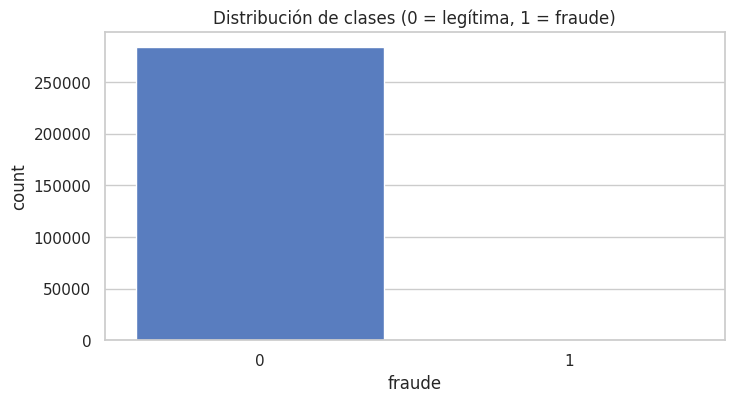

In [5]:
# Distribución de clases
sns.countplot(x="fraude", data=df)
plt.title("Distribución de clases (0 = legítima, 1 = fraude)")
plt.savefig(REPORTS_DIR/"dist_clases.png", bbox_inches="tight")
plt.show()

In [6]:
print(f'Importe máximo: {df["importe"].max():.2f} €')
print(f'Importe mínimo: {df["importe"].min():.2f} €')
print(f'Importe medio: {df["importe"].mean():.2f} €')
print(f'Importe mediano: {df["importe"].median():.2f} €')

Importe máximo: 25691.16 €
Importe mínimo: 0.00 €
Importe medio: 88.35 €
Importe mediano: 22.00 €


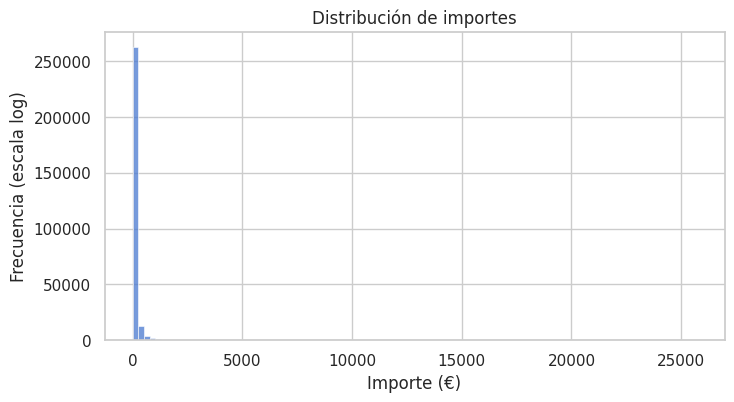

In [7]:
# Distribución de importes
sns.histplot(df["importe"], bins=100, log_scale=(False, False))
plt.title("Distribución de importes")
plt.xlabel("Importe (€)")
plt.ylabel("Frecuencia (escala log)")
plt.savefig(REPORTS_DIR/"dist_importes.png", bbox_inches="tight")
plt.show()

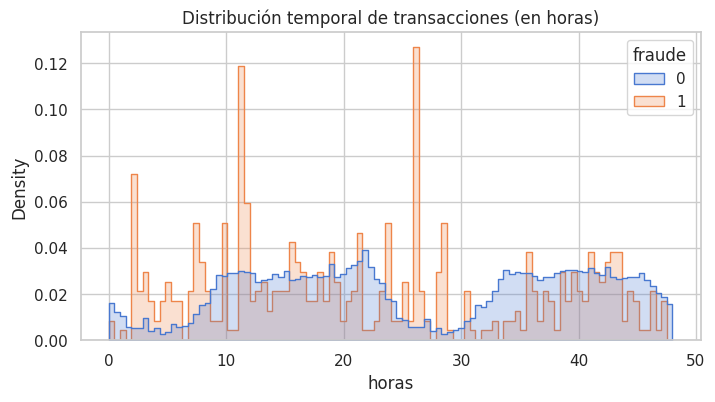

In [8]:
# Distribución temporal
df["horas"] = df["segundos_desde_inicio"] / 3600
sns.histplot(data=df, x="horas", hue="fraude", bins=100, element="step", stat="density", common_norm=False)
plt.title("Distribución temporal de transacciones (en horas)")
plt.savefig(REPORTS_DIR/"dist_temporal.png", bbox_inches="tight")
plt.show()

## Modelos baseline (clásicos y gradient boosting)
Probamos tres clasificadores sencillos:
- Regresión logística
- Random Forest
- LightGBM

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score

# Usar las features que ya tengas (por ejemplo importe + delta_t + etc.)
X = df.drop(columns=["fraude"])
y = df["fraude"]

# Importante: split temporal (no aleatorio) para evitar fuga
split_idx = int(len(df) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Modelos
modelos = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()), 
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ]),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, class_weight="balanced", n_jobs=-1, random_state=7
    ),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=64,
        class_weight="balanced",
        random_state=7
    )
}

# Entrenar y evaluar
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred_prob = modelo.predict_proba(X_test)[:,1] if hasattr(modelo, "predict_proba") else modelo.decision_function(X_test)
    
    roc = roc_auc_score(y_test, y_pred_prob)
    pr  = average_precision_score(y_test, y_pred_prob)
    
    print(f"{nombre} -> ROC-AUC: {roc:.3f} | PR-AUC: {pr:.3f}")


LogisticRegression -> ROC-AUC: 0.980 | PR-AUC: 0.766
RandomForest -> ROC-AUC: 0.968 | PR-AUC: 0.817
[LightGBM] [Info] Number of positive: 384, number of negative: 198980
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7905
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
LightGBM -> ROC-AUC: 0.978 | PR-AUC: 0.813


## Conclusiones
- El dataset está **muy desbalanceado**: el fraude es extremadamente raro (<0.2%).
- La distribución de importes es muy sesgada hacia valores bajos.